In [24]:
#import dependencies
import keras
from keras.models import Sequential
from keras import utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.datasets import cifar10
from keras import regularizers, optimizers, initializers
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Feb  7 21:32:25 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [4]:
# Download dataset from Google Drive
! gdown --id 1ZdK5f5rbR4E7rzzAIXm84L8Mjp9HCfS0

# Links

# Zero Pad 128: 1-9hnSKSnqQmELI5_PAPy9BhLDc-bKEbE

# White Pad 128: 1ZdK5f5rbR4E7rzzAIXm84L8Mjp9HCfS0

# Zero Pad 224: 1-9sy-KxqUqBsW-GcsvfThzQL-0QiMfBS

# White Pad 224: 1-6ekgyym3PYND6Z9oRlVo8sE5XV8B_km

# Zero Pad 512: 1-DYICH8IyqrQh--WprRTrpYDzS-QgUc0

# White Pad 512: 1-AmotnWWdvKNxYlkGCS4BkrLY1BnrnaU

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:138: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1ZdK5f5rbR4E7rzzAIXm84L8Mjp9HCfS0
From (redirected): https://drive.google.com/uc?id=1ZdK5f5rbR4E7rzzAIXm84L8Mjp9HCfS0&confirm=t&uuid=785ec1a7-5f35-4491-b544-184e5350b169
To: /content/White_Pad_128.zip
100% 209M/209M [00:02<00:00, 75.8MB/s]


In [5]:
! mkdir data
!unzip White_Pad_128.zip

Streaming output truncated to the last 5000 lines.
 extracting: content/white_pad_128/1_Sclerotic/S-1909-007195_PAS_2of2_647582c3435c92704a444147.png  
  inflating: content/white_pad_128/1_Sclerotic/S-2006-001849_PAS_1of2_64542f6e435c92704a3575ff.png  
  inflating: content/white_pad_128/1_Sclerotic/S-1910-000090_PAS_1of2_64551d4e435c92704a3d0f4c.png  
  inflating: content/white_pad_128/1_Sclerotic/S-2102-006457_PAS_2of2_645527ff435c92704a3ef449.png  
  inflating: content/white_pad_128/1_Sclerotic/S-2010-013043_PAS_1of2_64552795435c92704a3e03c2.png  
  inflating: content/white_pad_128/1_Sclerotic/S-2006-003978_PAS_2of2_645432e3435c92704a38b27a.png  
  inflating: content/white_pad_128/1_Sclerotic/S-1908-009734_PAS_2of2_64551cdf435c92704a3c452b.png  
  inflating: content/white_pad_128/1_Sclerotic/S-2102-006457_PAS_2of2_645527ff435c92704a3ef441.png  
 extracting: content/white_pad_128/1_Sclerotic/S-2103-004716_PAS_2of2_64552857435c92704a3faeb0.png  
  inflating: content/white_pad_128/1_Scl

In [6]:
! mv content/* data

In [7]:
!pip install split-folders
import splitfolders
splitfolders.ratio('/content/data/white_pad_128', output="output", seed=1345, ratio=(0.8, 0.1,0.1))

Copying files: 5758 files [00:01, 3117.06 files/s]


In [8]:
from PIL import Image
import os

# Specify the paths to your train, val, and test folders containing your PNG images
train_folder = "/content/output/train"
val_folder = "/content/output/val"
test_folder = "/content/output/test"

def load_images_and_labels(folder_path):
    x_data = []
    y_data = []

    for subfolder in os.listdir(folder_path):
        subfolder_path = os.path.join(folder_path, subfolder)
        if os.path.isdir(subfolder_path):
            label = int(subfolder.split('_')[0])  # Assuming the folder names are 0 or 1

            for image_name in os.listdir(subfolder_path):
                image_path = os.path.join(subfolder_path, image_name)

                # Open image and convert to numpy array
                img = Image.open(image_path)
                img_array = np.array(img)

                # Append data to arrays
                x_data.append(img_array)
                y_data.append(label)

    return np.array(x_data), np.array(y_data)

# Load train data
x_train, y_train = load_images_and_labels(train_folder)

# Load validation data
x_val, y_val = load_images_and_labels(val_folder)

# Load test data
x_test, y_test = load_images_and_labels(test_folder)

# Now, x_train, y_train, x_val, y_val, x_test, y_test contain your image data and labels in NumPy arrays.

# Print the shape of the resulting array
print("Shape of x_train:", x_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of x_val:", x_val.shape)
print("Shape of y_val:", y_val.shape)
print("Shape of x_test:", x_test.shape)
print("Shape of y_test:", y_test.shape)


Shape of x_train: (4606, 128, 128, 3)
Shape of y_train: (4606,)
Shape of x_val: (575, 128, 128, 3)
Shape of y_val: (575,)
Shape of x_test: (577, 128, 128, 3)
Shape of y_test: (577,)


In [9]:
# Normalize the data to speed up training
mean = np.mean(x_train)
std = np.std(x_train)
x_train = (x_train-mean)/(std+1e-7)
x_val = (x_val-mean)/(std+1e-7)
x_test = (x_test-mean)/(std+1e-7)

# let's look at the normalized values of a sample image
x_train[0]

array([[[1.32206792, 1.32206792, 1.32206792],
        [1.32206792, 1.32206792, 1.32206792],
        [1.32206792, 1.32206792, 1.32206792],
        ...,
        [1.32206792, 1.32206792, 1.32206792],
        [1.32206792, 1.32206792, 1.32206792],
        [1.32206792, 1.32206792, 1.32206792]],

       [[1.32206792, 1.32206792, 1.32206792],
        [1.32206792, 1.32206792, 1.32206792],
        [1.32206792, 1.32206792, 1.32206792],
        ...,
        [1.32206792, 1.32206792, 1.32206792],
        [1.32206792, 1.32206792, 1.32206792],
        [1.32206792, 1.32206792, 1.32206792]],

       [[1.32206792, 1.32206792, 1.32206792],
        [1.32206792, 1.32206792, 1.32206792],
        [1.32206792, 1.32206792, 1.32206792],
        ...,
        [1.32206792, 1.32206792, 1.32206792],
        [1.32206792, 1.32206792, 1.32206792],
        [1.32206792, 1.32206792, 1.32206792]],

       ...,

       [[1.32206792, 1.32206792, 1.32206792],
        [1.32206792, 1.32206792, 1.32206792],
        [1.32206792, 1

In [10]:
# let's display the labels
y_train

array([1, 1, 1, ..., 0, 0, 0])

In [15]:
# Homemade Model 1: 3 CN layers, 2 Dense layers, NO MaxPooling, Increase Dropout to 0.3,
# add weight decay to optimizer, He initialization

initializer = initializers.HeNormal()

# Model 10 had a little overfitting due to 3 Dense layers
# Model 11 had no overfiting, but performance was less than Model 10

# So, add one CNN layer to Model 11 and increase Dropout to 0.3


# build the model

# number of hidden units variable
base_hidden_units = 16

# l2 regularization hyperparameter
weight_decay = 1e-4

# instantiate an empty sequential model
model = Sequential()

# CONV1
model.add(Conv2D(base_hidden_units, (3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay), bias_regularizer=regularizers.L2(weight_decay), kernel_initializer=initializer, input_shape=x_train.shape[1:]))
model.add(BatchNormalization())

# CONV2
model.add(Conv2D(2*base_hidden_units, (3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay), bias_regularizer=regularizers.L2(weight_decay), kernel_initializer=initializer))
model.add(BatchNormalization())

# CONV3
model.add(Conv2D(4*base_hidden_units, (3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay), bias_regularizer=regularizers.L2(weight_decay), kernel_initializer=initializer))
model.add(BatchNormalization())

# FCN

model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(64, activation = 'relu', kernel_regularizer=regularizers.l2(weight_decay), bias_regularizer=regularizers.L2(weight_decay), kernel_initializer=initializer))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(32, activation = 'relu', kernel_regularizer=regularizers.l2(weight_decay), bias_regularizer=regularizers.L2(weight_decay), kernel_initializer=initializer))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(weight_decay), bias_regularizer=regularizers.L2(weight_decay), kernel_initializer=initializer))

# print model summary
model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 128, 128, 16)      448       
                                                                 
 batch_normalization_18 (Ba  (None, 128, 128, 16)      64        
 tchNormalization)                                               
                                                                 
 conv2d_13 (Conv2D)          (None, 128, 128, 32)      4640      
                                                                 
 batch_normalization_19 (Ba  (None, 128, 128, 32)      128       
 tchNormalization)                                               
                                                                 
 conv2d_14 (Conv2D)          (None, 128, 128, 64)      18496     
                                                                 
 batch_normalization_20 (Ba  (None, 128, 128, 64)     

He initialization
When your neural network is ReLU activated, He initialization is one of the methods you can choose to bring the variance of those outputs to approximately one (He et al., 2015).

Although it attempts to do the same, He initialization is different than Xavier initialization (Kumar, 2017; He et al., 2015). This difference is related to the nonlinearities of the ReLU activation function, which make it non-differentiable at [latex]x = 0[/latex]. However, Kumar indeed proves mathematically that for the ReLU activation function, the best weight initialization strategy is to initialize the weights randomly but with this variance:

\begin{equation} v^{2} = 2/N \end{equation}

...which is He initialization.

ReLU activating networks, which are pretty much the standard ones today, benefit from the He initializer - which does the same thing, but with a different variance, namely [latex]2/N[/latex].

Reference: https://github.com/christianversloot/machine-learning-articles/blob/main/he-xavier-initialization-activation-functions-choose-wisely.md


In [16]:
# data augmentation
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False
    )

# compute the data augmentation on the training set
datagen.fit(x_train)

In [17]:
# training
batch_size = 64
epochs=60

optimizer1 = keras.optimizers.Adam(learning_rate=0.0001,weight_decay=1e-6)


model.compile(loss='binary_crossentropy', optimizer=optimizer1, metrics=['accuracy'])

In [18]:
# Start timing
start_time = time.time()  # Record start time


history1 = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                steps_per_epoch=x_train.shape[0] // batch_size, epochs=epochs,
                validation_data=(x_val,y_val))

end_time = time.time()  # Record end time

training_time = end_time - start_time
print("Training time: {} seconds".format(training_time))

<ipython-input-18-5ded50dafd2d>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history1 = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),


Epoch 1/60
71/71 [==============================] - 55s 522ms/step - loss: 0.7057 - accuracy: 0.7215 - val_loss: 0.6869 - val_accuracy: 0.7130
Epoch 2/60
71/71 [==============================] - 24s 331ms/step - loss: 0.4644 - accuracy: 0.8633 - val_loss: 0.3840 - val_accuracy: 0.8783
Epoch 3/60
71/71 [==============================] - 25s 347ms/step - loss: 0.4236 - accuracy: 0.8840 - val_loss: 0.2917 - val_accuracy: 0.9113
Epoch 4/60
71/71 [==============================] - 23s 323ms/step - loss: 0.4055 - accuracy: 0.9038 - val_loss: 0.2531 - val_accuracy: 0.9426
Epoch 5/60
71/71 [==============================] - 22s 311ms/step - loss: 0.3626 - accuracy: 0.9212 - val_loss: 0.2594 - val_accuracy: 0.9287
Epoch 6/60
71/71 [==============================] - 23s 319ms/step - loss: 0.3379 - accuracy: 0.9232 - val_loss: 0.2246 - val_accuracy: 0.9443
Epoch 7/60
71/71 [==============================] - 23s 324ms/step - loss: 0.3420 - accuracy: 0.9287 - val_loss: 0.2207 - val_accuracy: 0.9548

In [19]:
# evaluating the model
scores = model.evaluate(x_test, y_test, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

5/5 [==============================] - 3s 329ms/step - loss: 0.1921 - accuracy: 0.9757

Test result: 97.574 loss: 0.192


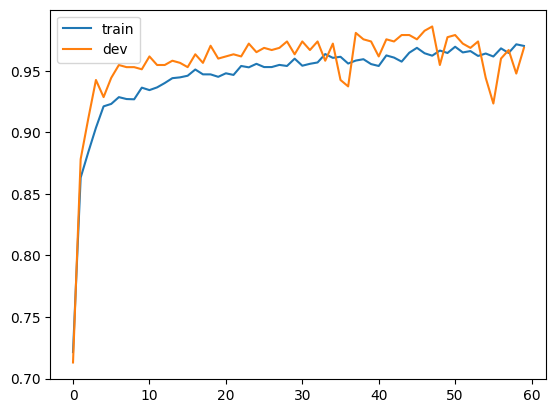

In [20]:
# plot learning curves of model accuracy
plt.plot(history1.history['accuracy'], label='train')
plt.plot(history1.history['val_accuracy'], label='dev')
plt.legend()
plt.savefig('HomemadeModel1.png')
plt.show()

19/19 [==============================] - 1s 29ms/step


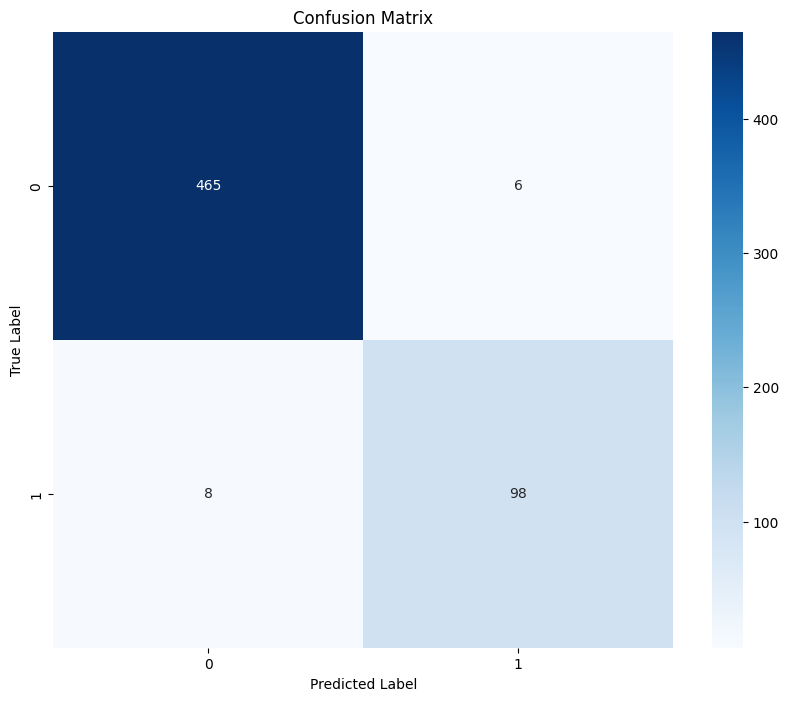

In [36]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

y_proba = model.predict(x_test)
# Threshold probabilities to get binary predictions
threshold = 0.5
y_pred = (y_proba > threshold).astype(int)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [37]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=['Non-Sclerotic ', 'Sclerotic']))

                precision    recall  f1-score   support

Non-Sclerotic        0.98      0.99      0.99       471
     Sclerotic       0.94      0.92      0.93       106

      accuracy                           0.98       577
     macro avg       0.96      0.96      0.96       577
  weighted avg       0.98      0.98      0.98       577



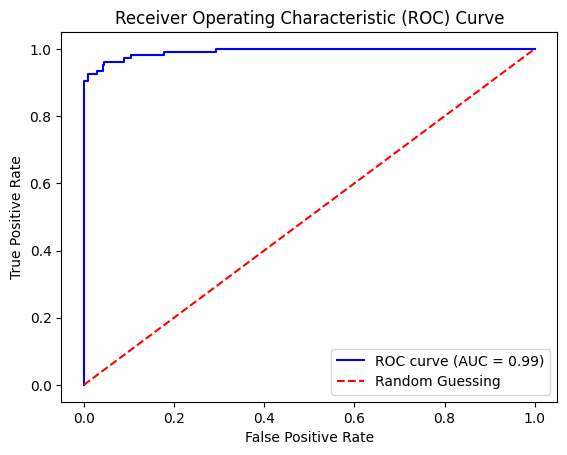

In [38]:
from sklearn.metrics import roc_curve, auc

# Calculate the false positive rate (FPR), true positive rate (TPR), and threshold values
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, color='blue', label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
#plt.savefig('.png')
plt.show()

Ideal Threshold

In [39]:
import pandas as pd
i = np.arange(len(tpr))
roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'thresholds' : pd.Series(thresholds, index=i)})
ideal_roc_thresh = roc.iloc[(roc.tf-0).abs().argsort()[:1]]  #Locate the point where the value is close to 0
print("Ideal threshold is: ", ideal_roc_thresh['thresholds'])

Ideal threshold is:  17    0.207789
Name: thresholds, dtype: float32


19/19 [==============================] - 0s 19ms/step


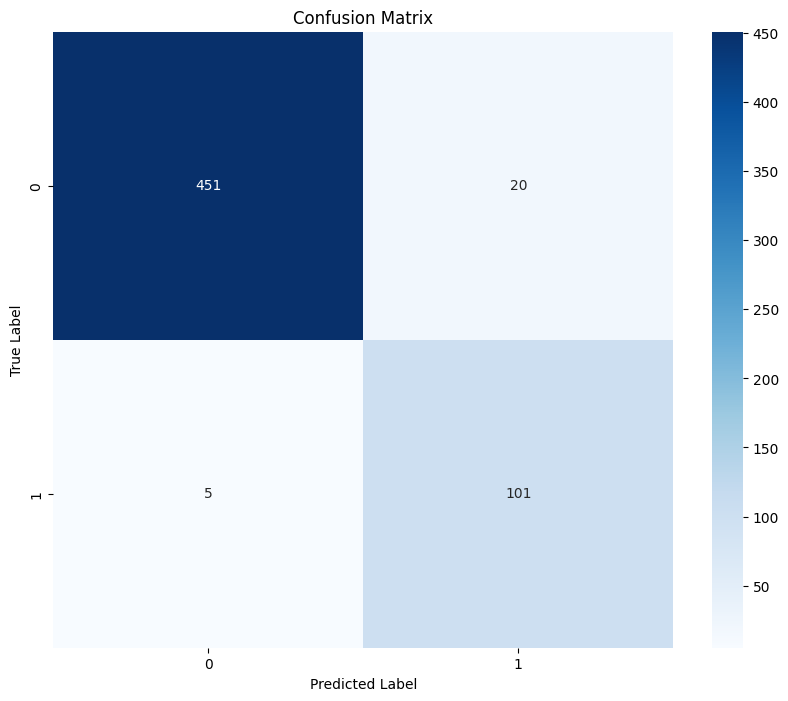

In [40]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

y_proba = model.predict(x_test)
# Threshold probabilities to get binary predictions
threshold =  0.207789
y_pred = (y_proba > threshold).astype(int)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [41]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=['Non-Sclerotic ', 'Sclerotic']))

                precision    recall  f1-score   support

Non-Sclerotic        0.99      0.96      0.97       471
     Sclerotic       0.83      0.95      0.89       106

      accuracy                           0.96       577
     macro avg       0.91      0.96      0.93       577
  weighted avg       0.96      0.96      0.96       577



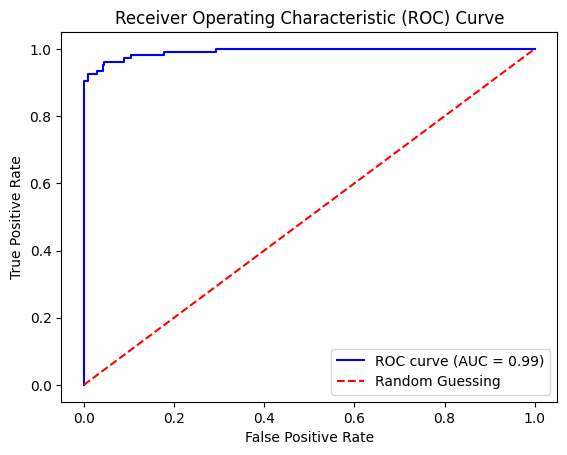

In [42]:
from sklearn.metrics import roc_curve, auc

# Calculate the false positive rate (FPR), true positive rate (TPR), and threshold values
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, color='blue', label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
#plt.savefig('VGG16_9epochs_ver2_roc_auc.png')
plt.show()

In [43]:
# Save the model
model.save('HomeMade_128x128.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
